In [1]:
import numpy as np
from matplotlib import pyplot as plt
import math

import torch
from torch.utils.data import Dataset, DataLoader, TensorDataset
from scipy.special import hermite, factorial

from pde_classes import *

%load_ext autoreload
%autoreload 2

In [2]:
device = torch.accelerator.current_accelerator().type if torch.accelerator.is_available() else "cpu"
print(f"Using device {device}")

Using device mps


In [6]:
torch.manual_seed(44)
np.random.seed(25)

# pinn = tiSchrodingerI(
#     device=device, 
#     num_points=100, 
#     state=4,
#     loss_pde_factor = 1,
#     loss_bc_factor = 100,
#     loss_norm_factor = 1,
#     loss_norm_exp_factor = 10
#     ).to(device)

# pinn = tiSchrodingerII(
#     device=device, 
#     num_points=100, 
#     state=0,
#     loss_pde_factor = 3,
#     loss_bc_factor = 1,
#     loss_norm_factor = 1,
#     loss_norm_exp_factor = 1
#     ).to(device)


pinn = tdSchrodingerI(    
    device=device, 
    num_x_points=100,
    num_t_points=10,
    state=1,
    loss_pde_factor=1,
    loss_bc_factor=100,
    loss_norm_factor=1,
    loss_norm_exp_factor=10
    ).to(device)



pinn.apply(init_weights)
optimizer = torch.optim.Adam(
    #list(pinn.net.parameters()) + [pinn.E],
    list(pinn.net.parameters()),
    lr=1e-3
)
scheduler = torch.optim.lr_scheduler.MultiStepLR(
    optimizer, milestones=[5000], gamma=0.1  # At epoch 8000, lr *= 0.1
)

epochs = 30000
num_batches = 1

dataset = TensorDataset(pinn.x_t_interior)
batch_size = int(len(dataset) / num_batches)
dataloader = DataLoader(dataset, batch_size, shuffle=True)

for epoch in range(epochs):
    for (x_batch,) in dataloader:
        optimizer.zero_grad()
        loss, loss_dict = pinn.loss(x_batch)
        loss.backward()
        optimizer.step()
    # scheduler.step()  # Step the scheduler at the end of each epoch

    if epoch % (epochs/30) == 0:
        #print(f"Epoch {epoch}, E = {pinn.E}, loss = {loss.item():.3e}, lr = {optimizer.param_groups[0]['lr']:.1e}")
        print(f"Epoch {epoch}")
        print(f"    E = {pinn.E:.3e}, norm = {loss_dict['norm'].item():.3e}, loss = {loss.item():.3e}")
        print(f"    loss_pde = {loss_dict['loss_pde'].item():.3e}, loss_bc = {loss_dict['loss_bc'].item():.3e}, loss_norm = {loss_dict['loss_norm'].item():.3e}")
        # print("loss_norm", loss_norm.item())
        # print("norm", norm.item())
        #print(f"Epoch {epoch}, E = {pinn.E.item():.4f}, loss = {loss.item():.3e}, lr = {optimizer.param_groups[0]['lr']:.1e}")
    if loss.item() < 1e-4:
        print(f"Stopping early at epoch {epoch} with loss {loss.item():.3e}")
        break

# Evaluate
#u_pred = pinn(pinn.x_t_test).detach().cpu().numpy()
u_pred = pinn.predict()



# # Plot
# plt.plot(pinn.x_t_test.cpu(), -u_pred, label="PINN")
# plt.plot(pinn.x_t_test.cpu(), pinn.u_true, '--', label="Analytical")
# plt.legend()
# plt.xlabel("x")
# plt.ylabel("u(x)")
# plt.title("PINN solution of PDE")
# plt.grid(True)
# plt.show()

%matplotlib inline
from matplotlib import rc
rc('animation', html='jshtml')  

ani = pinn.make_plot(u_pred)
ani  # inline display if using rc('animation', html='jshtml')



Epoch 0
    E = 9.870e+00, norm = 1.121e-02, loss = 1.762e+04
    loss_pde = 8.296e-04, loss_bc = 1.158e+00, loss_norm = 1.762e+04
Epoch 1000
    E = 9.870e+00, norm = 5.220e-01, loss = 5.581e+01
    loss_pde = 5.027e-01, loss_bc = 4.627e+01, loss_norm = 8.821e+00
Epoch 2000
    E = 9.870e+00, norm = 5.425e-01, loss = 4.411e+01
    loss_pde = 1.841e+00, loss_bc = 3.505e+01, loss_norm = 7.112e+00
Epoch 3000
    E = 9.870e+00, norm = 5.519e-01, loss = 4.012e+01
    loss_pde = 2.028e+00, loss_bc = 3.146e+01, loss_norm = 6.447e+00
Epoch 4000
    E = 9.870e+00, norm = 5.828e-01, loss = 2.767e+01
    loss_pde = 1.676e+00, loss_bc = 2.098e+01, loss_norm = 4.701e+00
Epoch 5000
    E = 9.870e+00, norm = 7.182e-01, loss = 7.064e+00
    loss_pde = 8.025e-01, loss_bc = 4.153e+00, loss_norm = 1.212e+00
Epoch 6000
    E = 9.870e+00, norm = 8.003e-01, loss = 3.859e+00
    loss_pde = 4.968e-01, loss_bc = 2.079e+00, loss_norm = 4.900e-01
Epoch 7000
    E = 9.870e+00, norm = 6.969e-01, loss = 6.218e+00


ani = pinn.make_plot(u_pred)
ani  # inline display if using rc('animation', html='jshtml')

In [29]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation

num_x_points_testing = 100
num_t_points_testing = 100

# Assume you already have:
# u_pred: (num_x_points_testing*num_t_points_testing, 2)
# num_x_points_testing, num_t_points_testing
# and the original torch x_interior_test_grid, t_interior_test_grid

# Convert grids to numpy
X = pinn.x_interior_test_grid.cpu().numpy()   # shape (Nx, Nt)
T = pinn.t_interior_test_grid.cpu().numpy()   # shape (Nx, Nt)


# Reshape u_pred into (Nx, Nt)
u_pred_real = u_pred[:, 0].reshape(num_x_points_testing, num_t_points_testing)
u_pred_imag = u_pred[:, 1].reshape(num_x_points_testing, num_t_points_testing)

# Probability density
prob_density = u_pred_real**2 + u_pred_imag**2

# Unique coordinate axes
x_vals = X[:, 0]     # (Nx,)
t_vals = T[0, :]     # (Nt,)

# --- Set up figure ---
fig, ax = plt.subplots(figsize=(7, 4))
line, = ax.plot([], [], lw=2)

ax.set_xlim(x_vals.min(), x_vals.max())
ax.set_ylim(0, prob_density.max()*1.1)
ax.set_xlabel("x")
ax.set_ylabel("|ψ(x,t)|² (Probability Density)")
title = ax.set_title("")

# --- Init ---
def init():
    line.set_data([], [])
    title.set_text("")
    return line, title

# --- Update function ---
def update(frame):
    y_prob = prob_density[:, frame]
    line.set_data(x_vals, y_prob)
    title.set_text(f"Probability Density |ψ|², t={t_vals[frame]:.2f}")
    return line, title

# --- Animation ---
ani = animation.FuncAnimation(
    fig, update, frames=len(t_vals),
    init_func=init, blit=True, interval=100
)

plt.close(fig)  # avoid extra static plot in Jupyter
ani  # inline display if using rc('animation', html='jshtml')

# Save to GIF (embed in GitHub README)
#ani.save("psi_probability.gif", fps=20)


In [ ]:
# from scipy.special import hermite
# from scipy.special import factorial
# x_test = np.linspace(-5,5,200)

# def u_true_func(x, n):
#     """Calculate the true solution for the nth state."""
#     Hn = hermite(n)
#     return (1.0 / np.sqrt(2**n * factorial(n))) * (1 / np.pi**0.25) * Hn(x) * np.exp(-x**2 / 2)

# # plot
# for n in range(6):
#     plt.plot(pinn.x_test.cpu(), -u_pred, label="PINN")
#     plt.plot(x_test, u_true_func(x_test,n), '--', label="Analytical")
#     plt.legend()
#     plt.title(f"E={n+1/2:.1f}")
#     plt.xlabel("x")
#     plt.ylabel("u(x)")
#     plt.title(f"PINN solution of PDE: E={n+1/2:.2f}")
#     plt.grid(True)
#     plt.show()



print(u_pred.shape)

a = u_pred[:,0].reshape(-1, 1)[:]

plt.plot()

print(a.shape)
#print(pinn.u_true.shape)
#print(pinn.x_t_test.shape)

(10000, 2)
(10000, 1)


In [ ]:
a = np.array([1,2,30])

b = torch.tensor(a)

c = torch.linspace(b[1],b[2],10)
print(c)

# import numpy as np
# import matplotlib.pyplot as plt
# import ipywidgets as widgets
# from IPython.display import display

# # Spatial domain
# x = np.linspace(0, 1, 10)

# # Function of (x, t)
# def f(x, t):
#     return np.sin(np.pi * x) * np.cos((np.pi**2) * t)

# # Plot function for a given t
# def plot_for_time(t):
#     y = f(x, t)
#     plt.figure(figsize=(6,4))
#     plt.plot(x, y, lw=2)
#     plt.ylim(-1.5, 1.5)
#     plt.xlabel("x")
#     plt.ylabel("f(x,t)")
#     plt.title(f"Function at t = {t:.2f}")
#     plt.grid(True)
#     plt.show()

# # Interactive slider (t from 0 to 1 in steps of 0.01)
# widgets.interact(plot_for_time, t=(0, 1, 0.1))

interactive(children=(FloatSlider(value=0.0, description='t', max=1.0), Output()), _dom_classes=('widget-inter…

<function __main__.plot_for_time(t)>

MovieWriter ffmpeg unavailable; using Pillow instead.


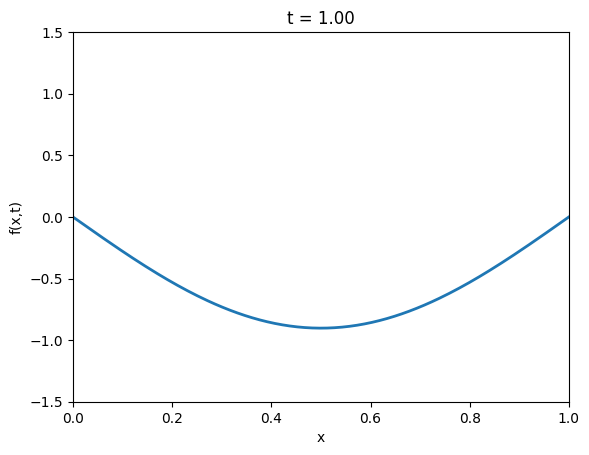

In [10]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation

# Spatial domain
x = np.linspace(0, 1, 200)

# Function f(x,t)
def f(x, t):
    return np.sin(np.pi * x) * np.cos((np.pi**2) * t)

# Time values
t_vals = np.linspace(0, 1, 100)

# Set up the figure
fig, ax = plt.subplots()
line, = ax.plot([], [], lw=2)
ax.set_xlim(0, 1)
ax.set_ylim(-1.5, 1.5)
ax.set_xlabel("x")
ax.set_ylabel("f(x,t)")
title = ax.set_title("")

# Init
def init():
    line.set_data([], [])
    title.set_text("")
    return line, title

# Update function
def update(frame):
    t = t_vals[frame]
    y = f(x, t)
    line.set_data(x, y)
    title.set_text(f"t = {t:.2f}")
    return line, title

# Animation
ani = animation.FuncAnimation(fig, update, frames=len(t_vals),
                              init_func=init, blit=True, interval=100)

ani  # <- In Jupyter, just returning ani displays the animation inline

ani.save("psi_evolution.gif", fps=20)     # GIF
